# Field inference for multiple dipole sources

This notebook demonstrates that it is possible to learn analytical forms like the dipole field with good accuracy with a physically credible network and desirable scaling behaviour. In this demonstration, we want to model the potential/field from multiple fixed sources at arbitrary field points, and to do so while running over the sources and inference points separately; i.e. O(M + N) and not O(M * N).

We suppose this to be possible because of the principle of superposition for potentials / fields, and our implementation separately the input of magnetic sources (the 'priming' network) from the inference ('main' network). In particular, we try learning a hypernetwork where the role of the priming network is to output the weights for the main network. We will use jax, equinox and optax to develop a model combining neural and analytical (autodiff) components.

In [46]:
import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import optax
import scienceplots  # noqa

plt.style.use(["science", "ieee"])

In [47]:
def scalar_potential(r0, r):
    core = 0.25
    d = r - r0
    close_to_source = jnp.linalg.norm(d) < core
    interior = 1.0 / core / (2 * jnp.pi * core)
    exterior = 1.0 / d / (2 * jnp.pi * d)
    return jnp.where(close_to_source, interior, exterior)


def generate_total_potential(r0, r):
    points = jax.vmap(scalar_potential, in_axes=(None, 0))
    batch = jax.vmap(points, in_axes=(0, None))
    potential = jax.vmap(batch, in_axes=(1, None))(r0, r)
    return jnp.sum(potential, axis=0)

In [48]:
M = 1
N = 100
lim, res = 3, 1000

key = jr.PRNGKey(42 - 1)
key, subkey = jr.split(key, 2)

r0 = jr.normal(key=subkey, shape=(N, M))
x = np.linspace(-lim, lim, res)
potential = generate_total_potential(r0, x)

In [49]:
class HyperModel(eqx.Module):
    a_n: eqx.nn.MLP
    b_n: eqx.nn.MLP
    bias: eqx.nn.Linear

    def __init__(self, width, order, keys):
        self.a_n = eqx.nn.MLP(
            "scalar", order - 1, width, 3, jax.nn.gelu, key=keys.pop()
        )
        self.b_n = eqx.nn.MLP(
            "scalar", order - 1, width, 3, jax.nn.gelu, key=keys.pop()
        )
        self.bias = eqx.nn.Linear("scalar", "scalar", key=keys.pop())

    def __call__(self, r0):
        weights = lambda fun: jnp.sum(jax.vmap(fun)(r0), axis=0)
        return weights(self.a_n), weights(self.b_n), weights(self.bias)


class FourierModel(eqx.Module):
    hypermodel: HyperModel
    order: int

    def __init__(self, width, order, lim, keys):
        self.hypermodel = HyperModel(width, order, keys)
        self.order = order

    def fourier(self, r, a_n, b_n, bias):
        omega = 2 * jnp.pi * jnp.arange(1, self.order) / (2 * lim)
        expansion = a_n * jnp.cos(omega * r) + b_n * jnp.sin(omega * r)
        return bias + jnp.sum(expansion)

    def __call__(self, r0, r):
        output = lambda r0, r: self.fourier(r, *self.hypermodel(r0))
        return jax.vmap(jax.vmap(output, in_axes=(None, 0)), in_axes=(0, None))(r0, r)

In [50]:
def loss(model, r0, r, target):
    return jnp.mean(optax.huber_loss(model(r0, r), target))


@eqx.filter_jit
def error(model, r0, r, target):
    diff = jnp.abs(target - model(r0, r))
    return jnp.median(diff / jnp.abs(target) * 100, axis=1).mean()


optim = optax.adam(learning_rate=0.005)


@eqx.filter_jit
def train_step(model, opt_state, r0, r, y):
    loss_value, grads = eqx.filter_value_and_grad(loss)(model, r0, r, y)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value


@eqx.filter_jit
def validation_set(model, subkey, size=1_000):
    subkey1, subkey2 = jr.split(subkey, 2)
    r0 = jr.normal(key=subkey1, shape=(N, M))
    x = jr.uniform(key=subkey2, shape=(size, 1), minval=-lim, maxval=lim).squeeze()
    potential = generate_total_potential(r0, x)
    return error(model, r0, x, potential)

In [51]:
key = jr.PRNGKey(42 + 1)
key, *keys = jr.split(key, 6)
width, order = 64, 32

model = FourierModel(width, order, lim, keys)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

steps = 10_000
logger = {"train_loss": [], "train_err": [], "val_err": []}
for step in range(steps):
    model, opt_state, train_loss = train_step(model, opt_state, r0, x, potential)
    if (step % (steps / 100)) == 0:
        logger["train_loss"].append(train_loss)
        logger["train_err"].append(error(model, r0, x, potential))

        # Generate validation data
        key, subkey = jr.split(key, 2)
        logger["val_err"].append(validation_set(model, subkey))
    if (step % (steps / 10)) == 0:
        print(
            f"{step=}, train_loss={train_loss:.4f}, ",
            f"error={logger['train_err'][-1]:.4f}",
            f"val_error={logger['val_err'][-1]:.4f}",
        )

key, subkey = jr.split(key, 2)
rge = validation_set(model, subkey)
print(f"Final error: {rge:.2f}%")

step=0, train_loss=0.4775,  error=1006.0810 val_error=1222.4983
step=1000, train_loss=0.0015,  error=20.4541 val_error=16.9480
step=2000, train_loss=0.0008,  error=15.7597 val_error=16.4856
step=3000, train_loss=0.0008,  error=17.0862 val_error=18.8891
step=4000, train_loss=0.0009,  error=17.7320 val_error=14.9545
step=5000, train_loss=0.0006,  error=14.6597 val_error=40.3279
step=6000, train_loss=0.0005,  error=14.4031 val_error=13.3041
step=7000, train_loss=0.0004,  error=14.0092 val_error=138.9352
step=8000, train_loss=0.0004,  error=14.3371 val_error=100.0129
step=9000, train_loss=0.0004,  error=12.4032 val_error=11.2949
Final error: 14.51%


## Inference

The trained model can now accept arbitrary collections of source inputs and field points, and performs inference in O(N + M).

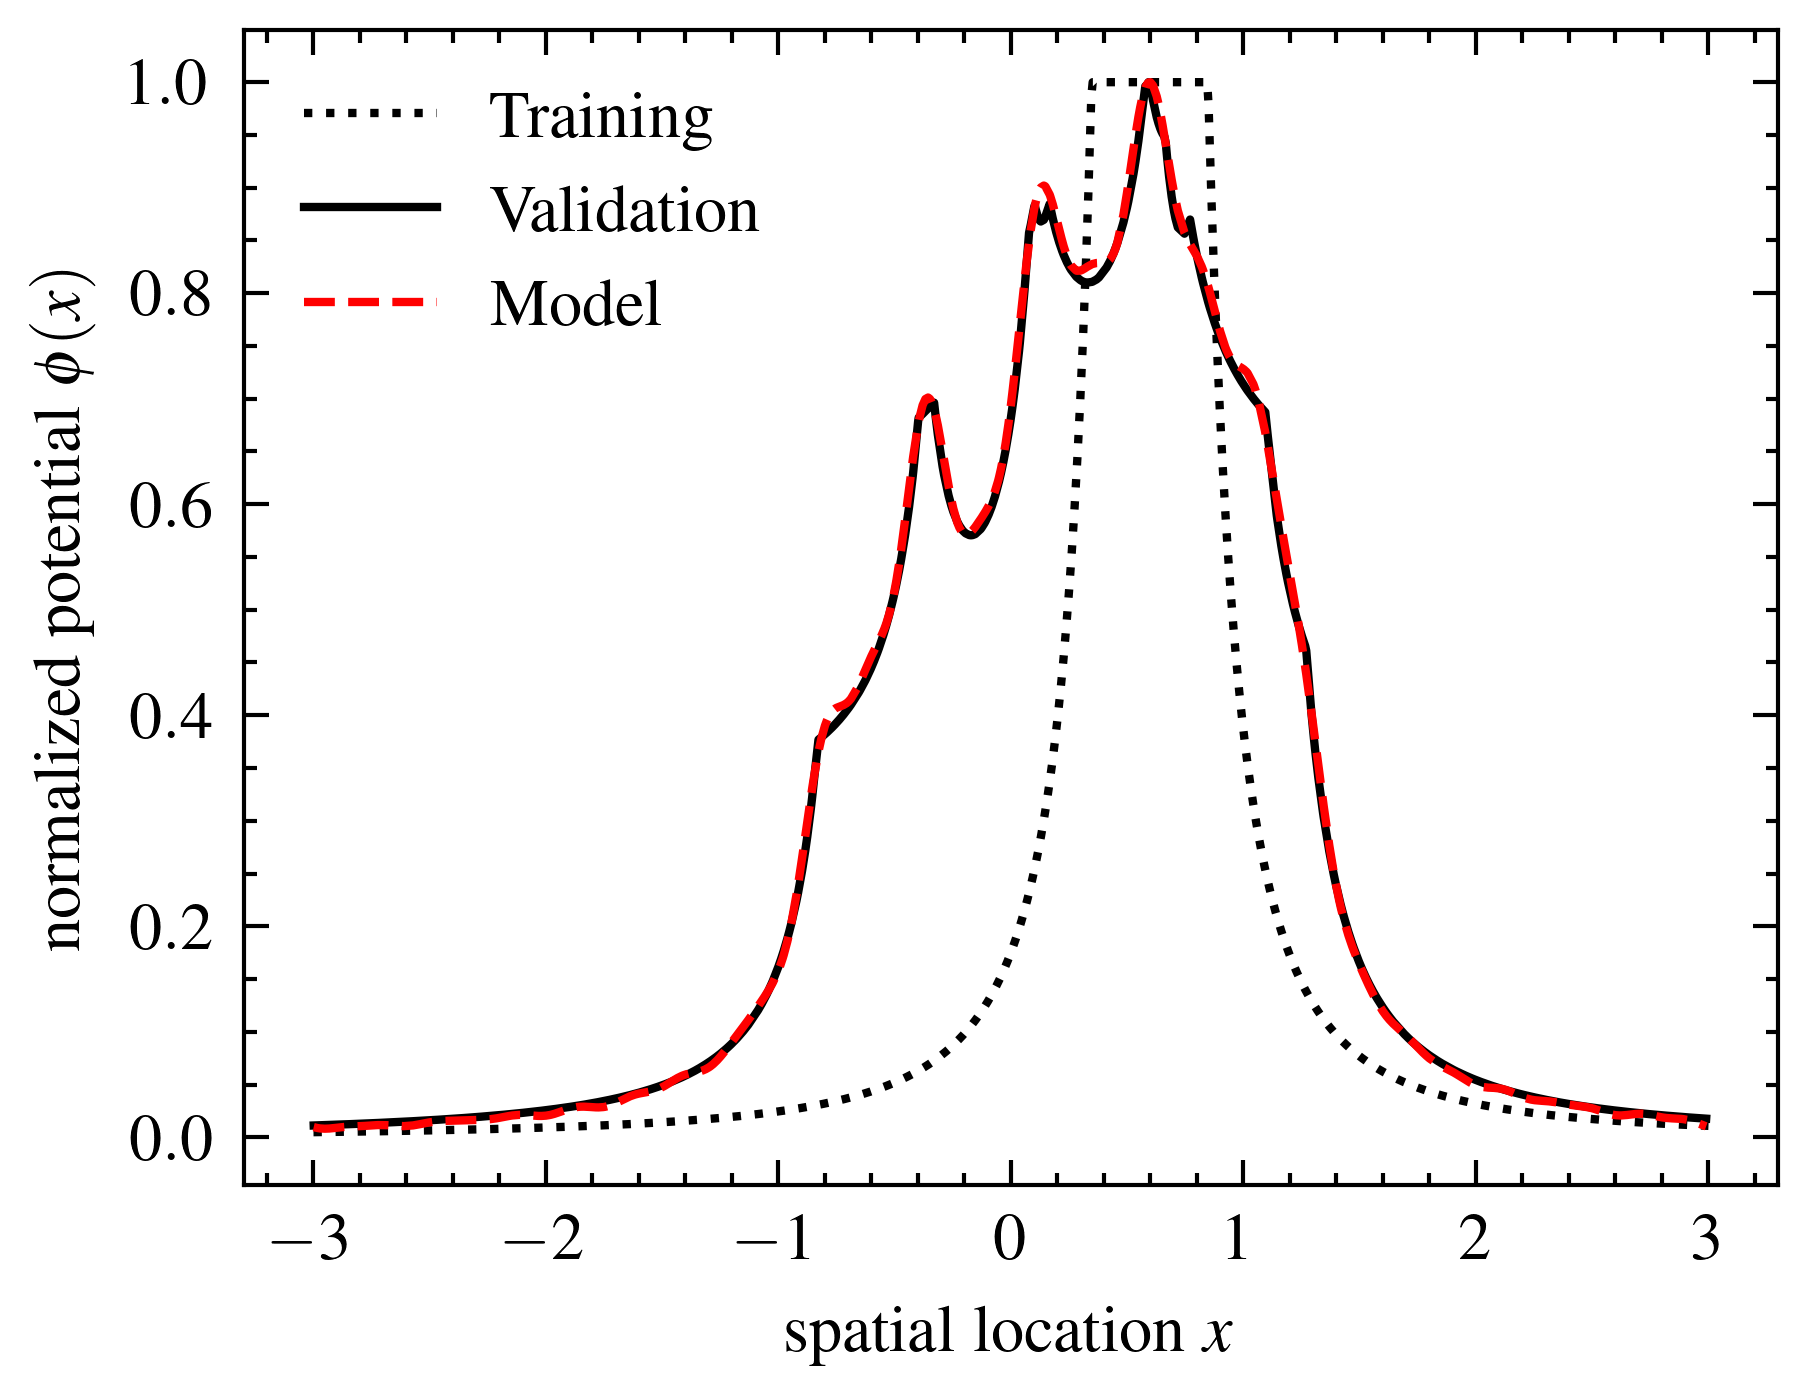

In [52]:
key = jr.PRNGKey(100 + 1)
key, *keys = jr.split(key, 4)
r0v = jr.normal(key=keys.pop(), shape=(1, 6))
xs = jnp.array(sorted(jr.uniform(keys.pop(), shape=(1000,), minval=-lim, maxval=lim)))

idx = 0
plt.xlabel("spatial location $x$")
plt.ylabel("normalized potential $\\phi(x)$")
plt.plot(x, potential[idx] / max(potential[idx]), "k:")
plt.plot(
    xs,
    generate_total_potential(r0v, xs)[idx]
    / max(generate_total_potential(r0v, xs)[idx]),
    "k-",
)
plt.plot(xs, model(r0v, xs)[idx] / max(model(r0v, xs)[idx]), "r--")
plt.legend(["Training", "Validation", "Model"], loc="upper left")